# Python Image I/O

`skia-python` supports several conversion between common data types in Python.

- [Image files](#Reading-and-writing-to-image-files)
- [NumPy array](#Numpy-array)
- [PIL Image](#Converting-image-from/to-PIL)

In [1]:
import skia
import PIL.Image
import numpy as np
import io
import matplotlib.pyplot as plt

from IPython.display import display

## Reading and writing to image files

`skia.Image` is the primary read-only image data structure in Skia. `skia.Image` can be read from an image file:

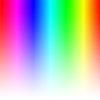

In [2]:
with open('../skia/resources/images/rainbow-gradient.png', 'rb') as f:
    image = skia.Image.DecodeToRaster(f.read())

display(image)

Or, can be exported via `skia.Surface.makeImageSnapshot` call:

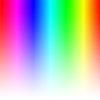

In [3]:
surface = skia.Surface(100, 100)
canvas = surface.getCanvas()
canvas.drawImage(image, 0, 0)  # Draw something to canvas
image = surface.makeImageSnapshot()

image

Write to a specific image format is available via `skia.Image.encodeToData`:

In [4]:
import tempfile

with tempfile.TemporaryFile(suffix='.png') as f:
    f.write(image.encodeToData(skia.kPNG, 100))

## NumPy array

NumPy arrays can be directly used as a pixel buffer. Mount `numpy.ndarray` as `skia.Canvas`:

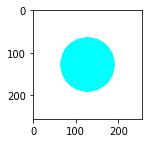

In [5]:
buffer = np.zeros((256, 256, 4), dtype=np.uint8)

canvas = skia.Canvas(buffer)
paint = skia.Paint(AntiAlias=True, Color=skia.ColorCYAN)
canvas.drawCircle((128, 128), 64, paint)
canvas.flush()

plt.figure(figsize=(2, 2))
plt.imshow(buffer)
plt.show()

NumPy arrays can be also used as a backend buffer for `Image`, `Pixmap`, or `Bitmap`.

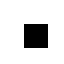

In [6]:
array = np.zeros((64, 64, 4), dtype=np.uint8)
array[24:48, 24:48, 3] = 255

image = skia.Image(array)

pixmap = skia.Pixmap(array)

bitmap = skia.Bitmap()
bitmap.setInfo(skia.ImageInfo.Make(64, 64, skia.kRGBA_8888_ColorType, skia.kUnpremul_AlphaType))
bitmap.setPixels(array)

display(image)

One pitfall is that generic pixel format is usually unpremultiplied alpha (`skia.kUnpremul_AlphaType`), but skia defaults to premultiplied alpha (`skia.kPremul_AlphaType`). Don't forget to specify `alphaType` parameter when needed.

Note that most APIs in skia does not copy buffer data but only shares a reference. Therefore, buffer lifetime should be carefully taken into account when converting between different format. The following results in crash.

```python
array = np.zeros((64, 64, 4), dtype=np.uint8)
image = skia.Image(array)
del array

image.encodeToData()  # This will crash
```

Exporting a numpy array is easy via `numpy` method:

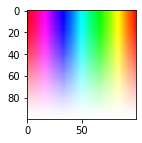

In [7]:
with open('../skia/resources/images/rainbow-gradient.png', 'rb') as f:
    image = skia.Image.DecodeToRaster(f.read())
    
array = image.numpy()

plt.figure(figsize=(2, 2))
plt.imshow(array)
plt.show()

Canvas or surface can also export to numpy array. This is convenient when surface backend is not raster.

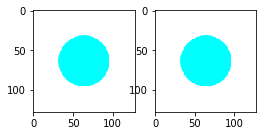

In [8]:
surface = skia.Surface(128, 128)
canvas = surface.getCanvas()
paint = skia.Paint(AntiAlias=True, Color=skia.ColorCYAN)
canvas.drawCircle((64, 64), 32, paint)

plt.figure(figsize=(4, 8))
plt.subplot(1, 2, 1), plt.imshow(canvas.numpy())
plt.subplot(1, 2, 2), plt.imshow(surface.numpy())
plt.show()

## Converting image from/to PIL

It is possible to directly convert `skia.Bitmap` or `skia.Pixmap` to `PIL.Image` using `fromarray`. Note that `PIL.Image` supports limited image modes, and most of the color types in skia are not compatible.

For `skia.Image`, first export to `skia.Bitmap` and then convert to `PIL.Image`:

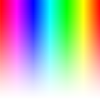

In [9]:
with open('../skia/resources/images/rainbow-gradient.png', 'rb') as f:
    skia_image = skia.Image.DecodeToRaster(f.read())

bitmap = skia_image.bitmap(colorType=skia.kRGBA_8888_ColorType)
PIL.Image.fromarray(bitmap)

Image is also convertible via encoded image buffer:

In [10]:
with io.BytesIO(skia_image.encodeToData()) as f:
    pil_image = PIL.Image.open(f)
    pil_image.load()  # Ensure to make a copy of buffer

Importing a `PIL.Image` is a bit involved. The easiest is to use encoded bytes:

In [11]:
with io.BytesIO() as f:
    pil_image.save(f, 'png')
    skia_image = skia.Image.DecodeToRaster(f.getvalue())  # This ensures the image is immediately decoded.

Alternatively, the following function demonstrates how to directly copy pixels from `PIL.Image` to `skia.Image`. In the following, the internal pixel buffer of `PIL.Image` is exported by `tobytes`, and directly mounted by `skia.Pixmap` with appropriately configured `skia.ImageInfo`. Then, `skia.Image` is constructed from the `skia.Pixmap`.

In [12]:
def convert_image_from_pil(pil_image):
    COLORTYPES = {
        'L': skia.kGray_8_ColorType,
        'RGB': skia.kRGB_888x_ColorType,
        'RGBA': skia.kRGBA_8888_ColorType,
    }
    assert pil_image.mode in COLORTYPES, 'Unsupported mode %r' % pil_image.mode
    info = skia.ImageInfo.Make(
        pil_image.width,
        pil_image.height,
        COLORTYPES.get(pil_image.mode),
        skia.AlphaType.kUnpremul_AlphaType)
    pixels = pil_image.tobytes()
    assert len(pixels) == info.computeMinByteSize(), 'Pixels do not match the expected size'
    pixmap = skia.Pixmap(info, pixels, info.minRowBytes())
    return skia.Image.MakeRasterCopy(pixmap)  # Ensure to copy; otherwise buffer might goes out of scope.


pil_image = PIL.Image.open('../skia/resources/images/rainbow-gradient.png')
skia_image = convert_image_from_pil(pil_image)